# 1. What interesting information user can find in the dataset?

###### Input data summary

 A. 109 whiskies are described by 5 characteristics: color (14 options),nose (12 options),body (8 options), palate (15 options), finish (19 options).

 B. for each whisky there is distillery assigned. Distillery might be identified by geographical coordinates (latitude/longitude) and region/district (which indicates macrogeographic location, such as proximity to the sea, altiude etc.)

 C. for each whisky there is score indicating quality (varies from 55% to 90%): score is based on one of references invoked in "Lapointe, F.-J. & P. Legendre. 1994. A classification of pure malt Scotch whiskies." study, which is starting point for this study.

###### Identified potential data applications


 A. relation between whisky quality score and different characteristics: check if whiskies scoring higher are more likely to have certain values of color,nose, body, palate and finish ?

 B. relation between distillery location/district/region and whisky's characteristics: is there any ? (for example, if distilleries of lower altitude tend to produce whisky of certain colour ?)

 C. similarity of whiskies (being analazyed in further part if this study): considering characteristics for each whisky, how "similar" they are to each other ?

# 2. Core code: determine whiskies similarity

ASSUMPTION: since questions in the task are related to taste preferences, distillery details (location etc) are omitted.

###### Define function for whisky distance, including only one characteristic

In [146]:
import pandas as pd
from math import *

#EUCLIDEAN DISTANCE: calculates distance of vectors
def euclidean_distance(x,y):
    return sqrt(sum(pow(a-b,2) for a,b in zip(x,y)))

#DISTANCE OF ONE WHISKY TO THE ALL OTHER WHISKIES, INCLUDING ONLY ONE CHARACTERISTIC
def char_distance(charFilename,whiskyID):
    df = pd.read_csv(charFilename,delimiter = " ", header = None, skiprows=1)# read data for specified characteristics
    x = df.iloc[whiskyID]
    y = df.iloc[whiskyID+1]
    distance = []
    for idx,row in df.iterrows():
        distance.append(euclidean_distance(x,row))
    df = pd.DataFrame(distance)
    return df
char_distance('BODY_PSutkowski.TXT',0) # EXAMPLE: test color similarity of whisky indexed as 1 to all whiskies

,0
0,0.000000
1,1.732051
2,2.000000
3,1.732051
4,1.000000
...,...
104,0.000000
105,1.000000
106,1.732051
107,1.732051


###### Define function that will calculate similarity of one whisky to another, including all characteristic.

ASSUMPTION: all characteristic are considered to have even weight

In [144]:
def whiskies_distance(charList,whiskyID):
    i=0
    for characteristic in charList:
        if i==0:
            df = pd.DataFrame(char_distance(characteristic,whiskyID))# read/process first characteristic
            i = 1
        else:
            df = df.join(char_distance(characteristic,whiskyID),rsuffix=charList[i]) #read/process further characteristics
            i=i+1           
    df.columns=charList # rename columns to match characteristics
    for characteristic in charList:
        df[characteristic] = df[characteristic]/df[characteristic].max()#normalize distance for each characteristic to be 0-1
    df['distance'] = df.mean(axis=1) # after averaging, total distance is average of distances
    df['name'] = pd.read_csv("NAMES_PSutkowski.txt",header=None) # read whiskies names from custom file
    df['score'] = pd.read_csv("SCORES_PSutkowski.txt",header=None) # read whiskies names from custom file
    return df
charList = ['COLOR.TXT','NOSE_PSutkowski.TXT','BODY_PSutkowski.TXT','PALATE.TXT','FINISH.TXT'] 

whiskies_distance(charList,77).sort_values(by='distance').head(10) # test
    

,COLOR.TXT,NOSE_PSutkowski.TXT,BODY_PSutkowski.TXT,PALATE.TXT,FINISH.TXT,distance,name,score
77,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Lagavulin,89
103,0.0,0.577350,0.845154,0.707107,0.500000,0.525922,Teaninich,71
87,0.0,0.745356,0.654654,0.790569,0.707107,0.579537,Mortlach,81
101,0.0,0.666667,0.755929,0.790569,0.790569,0.600747,Tamdhu,75
98,1.0,0.577350,0.654654,0.353553,0.612372,0.639586,Longrow,90
88,1.0,0.333333,0.845154,0.612372,0.612372,0.680646,North_Port,64
78,1.0,0.471405,0.654654,0.612372,0.707107,0.689107,Laphroaig,86
12,1.0,0.666667,0.845154,0.612372,0.353553,0.695549,Benrinnes,78
2,1.0,0.333333,0.845154,0.707107,0.612372,0.699593,Ardberg,85
39,1.0,0.666667,0.534522,0.612372,0.790569,0.720826,Glencadam,68


# 3. Data visualization and further processing

###### I' m choosing Lagavulin (ID77) as "whisky of interest"

Histogram of whisky distance from whisky of interest


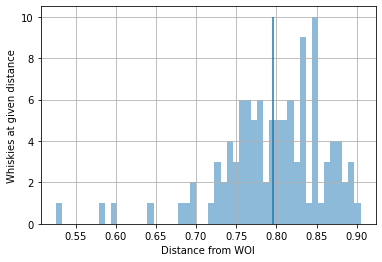

Mean distance of other whiskies from whisky of interest: 0.7961258988590365

Summary of closest whiskies:


,name,distance,score
103,Teaninich,0.525922,71
87,Mortlach,0.579537,81
101,Tamdhu,0.600747,75
98,Longrow,0.639586,90
88,North_Port,0.680646,64
78,Laphroaig,0.689107,86
12,Benrinnes,0.695549,78
2,Ardberg,0.699593,85


In [145]:
import matplotlib.pyplot as plt
WOI = 77 # variable for convenience
df = whiskies_distance(charList,WOI)
df2=df.drop([WOI],axis=0)#exlude WOI because it's obviously at 0 distance from itself
plt.hist(df2['distance'],alpha=0.5,bins=50)
plt.vlines(df2['distance'].mean(),ymin=0,ymax=10)
plt.xlabel('Distance from WOI')
plt.ylabel('Whiskies at given distance')
plt.grid(True)
print("Histogram of whisky distance from whisky of interest")
plt.show()
print("Mean distance of other whiskies from whisky of interest: " + str(df2['distance'].mean()))
print("\nSummary of closest whiskies:")
df2.loc[df2['distance']<0.7,['name','distance','score']].sort_values(by='distance')


###### Interim conclusion: distance between whisky of interest (WOI) and other whiskies is 0.80 on average. Looking at distance histogram, distance lower than 0.70 would indicate that whisky tend to be closer than other to WOI Therefore whiskies listed in the table above might be tested first in search of scotch similar to WOI. Testing might be performed at order of similarity (lower distance) or at order of score.

###### Let's see how WOI, "similar" whiskies and "distant" whiskies might be perceived in terms of considered characteristics

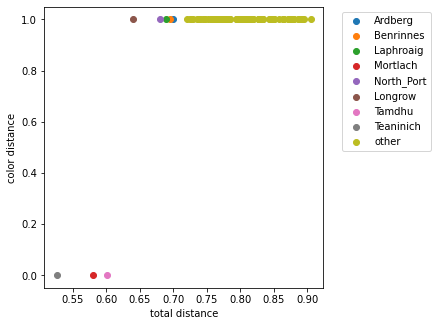

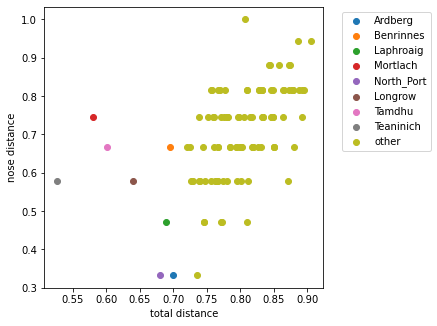

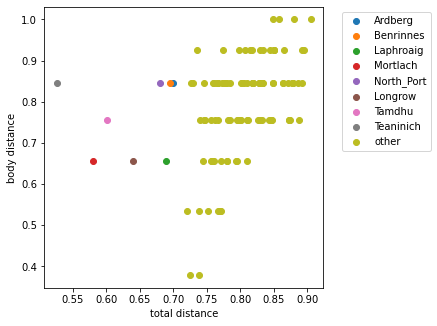

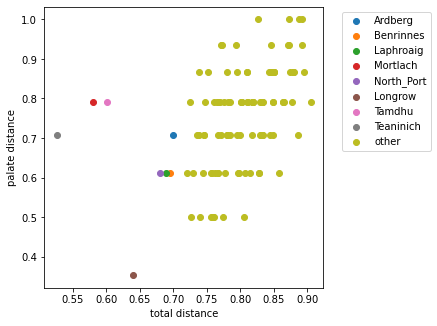

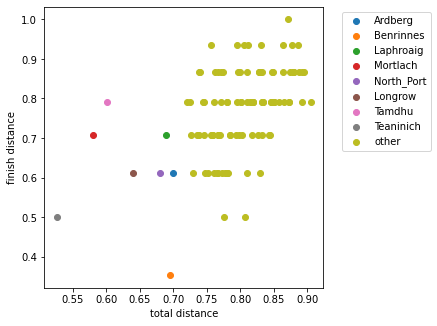

In [158]:
# rename headers in distance dataframe for convenience
df2.columns = ['color','nose','body','palate','finish','distance','name','score'] 
similar = df2.loc[df2['distance']<0.7,:]
other = df2.loc[df2['distance']>=0.7,:]

def plotTaste(data1,data2,label1,label2,xvar,yvar,index,totalPlots,xlabel,ylabel):
    plt.figure(figsize=(5,30))
    plt.subplot(totalPlots,1,index)
    for idx,row in data1.iterrows():
        plt.scatter(row[xvar],row[yvar],label = row['name'])
    plt.scatter(data2[xvar],data2[yvar],label = label2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
      
taste_chars = ['color','nose','body','palate','finish']
index = 1
for taste in taste_chars:
    plotTaste(similar,other,'similar','other','distance',taste,index,len(taste_chars),'total distance', taste + ' distance',)
    index=index+1

#plt.scatter(similar['distance'],similar['color'],label = 'similar')
#plt.scatter(other['distance'],other['color'], label = 'other')
#plt.xlabel('Total distance')
#plt.ylabel('Color distance')
#plt.legend(loc='upper left')